In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from model.holo import HoloConfig, HoloForCausalLM
from transformers import MambaConfig, MambaForCausalLM
import torch.optim as optim
from tqdm.notebook import tqdm 
import numpy as np
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import Dataset

class NIAHDataset(Dataset):
    def __init__(self, size, min_len, max_len, vocab_size):
        self.size = size
        self.min_len = min_len
        self.max_len = max_len
        self.vocab_size = vocab_size
        
        # Special Tokens
        self.start_tokens = torch.tensor([3, 4])
        self.trigger_tokens = torch.tensor([5, 4, 3, 6])
        self.flag_token = torch.tensor([2]) 

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # 1. Randomize Length for this specific sample
        # This prevents the model from overfitting to a specific horizon
        curr_len = np.random.randint(self.min_len, self.max_len + 1)
        
        # 2. Generate Key
        key = torch.randint(10, self.vocab_size, (1,))

        # 3. Calculate Noise
        # Overhead: Start(2) + Flag(1) + Key(1) + Trigger(4) + Target(1) = 9
        noise_len = curr_len - 9
        if noise_len < 0: noise_len = 0 # Safety clipping

        noise = torch.randint(10, self.vocab_size, (noise_len,))

        # 4. Insert Key Randomly
        insert_idx = torch.randint(0, noise_len + 1, (1,)).item()
        
        input_ids = torch.cat([
            self.start_tokens,
            noise[:insert_idx],
            self.flag_token,     # The Flag
            key,                 # The Needle
            noise[insert_idx:],
            self.trigger_tokens,
            key
        ])

        labels = input_ids.clone()
        labels[:-1] = -100 
        
        return {"input_ids": input_ids, "labels": labels}



In [3]:
SEQ_LEN = 20 
VOCAB_SIZE = 1000

train_dataset = NIAHDataset(size=50000, min_len = 10, max_len = 30,  vocab_size=VOCAB_SIZE)

In [4]:
examples = train_dataset[0]
input_ids, labels = examples['input_ids'], examples['labels']

print(f"Shape of the input_ids: {input_ids.shape}")
print(f"Shape of the labels: {labels.shape}")
print("\n")
print(f"Input_ids: {input_ids}")
print(f"Labels: {labels}")

Shape of the input_ids: torch.Size([28])
Shape of the labels: torch.Size([28])


Input_ids: tensor([  3,   4, 633, 900, 388, 489, 151,   2, 453, 940, 969, 186, 564, 842,
        942, 817, 216, 313, 450,  47, 518, 287, 966,   5,   4,   3,   6, 453])
Labels: tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100,  453])


In [5]:
def pad_collate_fn(batch):
    # Extract inputs and labels
    inputs = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Pad sequences to the longest in the batch (dynamic padding)
    # batch_first=True makes shape [Batch, Seq_Len]
    inputs_padded = rnn_utils.pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_padded = rnn_utils.pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {
        "input_ids": inputs_padded,
        "labels": labels_padded
    }

In [6]:
def calculate_accuracy(logits, labels):
    """
    Calculates accuracy for the final token prediction.
    
    Args:
        logits: [Batch, Seq_Len, Vocab] - The raw output from the model.
        labels: [Batch, Seq_Len] - The input_ids (or targets).
    
    Logic:
    The model predicts token[t+1] using the state at token[t].
    We want to check if the model correctly predicted the LAST token (Target).
    The state responsible for predicting the LAST token is the SECOND TO LAST token (Trigger).
    
    Index -1: The actual Target token (Ground Truth).
    Index -2: The Trigger token (Model output here predicts the Target).
    """
    # Check prediction at position -2 (The token BEFORE the target)
    key_logit = logits[..., -2, :] 
    pred_token = torch.argmax(key_logit, dim=-1)
    
    # Check against the actual Target (which is at -1 in the input/labels)
    target_token = labels[..., -1]
    
    return (pred_token == target_token).float().mean().item()

In [7]:
def train_eval_pipeline(model_name, model, train_loader, eval_seq_lens, vocab_size, device):
    """
    Args:
        model_name (str): Name for logging.
        model (nn.Module): The HF-style model (returns outputs.loss).
        train_loader (DataLoader): Loader for the fixed-length training data.
        eval_seq_lens (list): List of lengths to test generalization on (e.g. [256, 512, 1024]).
        vocab_size (int): Vocab size for generating eval data on the fly.
        device (str): 'cuda' or 'cpu'.
    """
    print(f"\n[{model_name}] Starting Training...")
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    model.train()

    # --- TRAINING PHASE ---
    # We use the train_loader which usually has a fixed sequence length (e.g. 256)
    # This replaces the "variable length loop" from the old code, 
    # relying on the model to learn the mechanism from the fixed length dataset.
    
    progress_bar = tqdm(train_loader, desc=f"Training {model_name}", leave=True)
    
    for step, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass (HF models compute loss automatically if labels are passed)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # --- EVALUATION PHASE (Length Generalization) ---
    print(f"\n[{model_name}] Evaluating Length Generalization...")
    results = []
    model.eval()
    
    for length in eval_seq_lens:
        # Generate a small temporary dataset for this specific length
        # This mirrors the 'generator_fn' logic from the old code
        # eval_ds = NIAHDataset(size=100, seq_len=length, vocab_size=vocab_size)
        eval_ds = NIAHDataset(size=100,
                              min_len = length, 
                              max_len = length,  
                              vocab_size=vocab_size)
        eval_loader = DataLoader(eval_ds, batch_size=1, shuffle=False)
        
        accs = []
        with torch.no_grad():
            for batch in eval_loader:
                input_ids = batch["input_ids"].to(device)

                try:
                    output = model(input_ids = input_ids)
                    acc = calculate_accuracy(output.logits, input_ids)
                    accs.append(acc)
                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        accs.append(0.0) 
                        torch.cuda.empty_cache()
                        break 
                    else:
                        raise e

        avg_acc = np.mean(accs)
        print(f"  Len {length}: {avg_acc:.2%}")
        results.append(avg_acc)
        
    return results


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
VOCAB_SIZE = 1000
MIN_SEQ_LEN = 32
MAX_SEQ_LEN = 256
BATCH_SIZE = 32

In [9]:
train_dataset = NIAHDataset(size=50000, min_len = 10, max_len = 30,  vocab_size=VOCAB_SIZE)

# 2. Create the DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=2,# Can use parallel loading now
    collate_fn=pad_collate_fn
)

iter_loader = next(iter(train_loader))
inputs_ids, labels = iter_loader['input_ids'], iter_loader['labels']

print(inputs_ids)
print(labels)

tensor([[  3,   4, 294, 607,   2, 478, 988, 844,   5,   4,   3,   6, 478,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  3,   4,  54, 307,   2, 781, 542, 569, 454, 987,   5,   4,   3,   6,
         781,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  3,   4, 148, 192, 990, 779, 450, 431, 521, 700, 653,  72,   2, 680,
         296,   5,   4,   3,   6, 680,   0,   0,   0,   0,   0],
        [  3,   4, 536, 982, 347, 717, 205, 520,   2, 193, 919, 259,  98, 368,
         431, 404, 616, 183, 861,  76,   5,   4,   3,   6, 193]])
tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          478, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100],
        [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100,  781, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100],
        [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100

In [10]:
train_dataset = NIAHDataset(size=200000, 
                            min_len = MIN_SEQ_LEN, 
                            max_len = MAX_SEQ_LEN,  
                            vocab_size=VOCAB_SIZE)

# 2. Create the DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,# Can use parallel loading now
    collate_fn=pad_collate_fn
)

# Use version 2 meaning that using the newest LongAttention inside the HOLOBlock
holo_config =  HoloConfig(
    d_model=128, 
    num_hidden_layers = 2,
    num_heads = 4,
    vocab_size=VOCAB_SIZE, 
    resid_dropout = 0.0, 
    dropout = 0.0,
    use_version=2
)
holo_model = HoloForCausalLM(holo_config).to(device)


config_kwargs = {
     "vocab_size": VOCAB_SIZE, 
     "ssm_cfg": {"dropout": 0.0 }
}
mamba_config = MambaConfig(
    hidden_size = 128,
    num_hidden_layers = 2, 
    **config_kwargs
)

mamba_model = MambaForCausalLM(mamba_config).to(device)

In [11]:
results_mamba = train_eval_pipeline(
        "Mamba", 
        mamba_model, 
        train_loader, 
        eval_seq_lens=[2**i for i in range(8, 21)], 
        vocab_size=VOCAB_SIZE, 
        device=device
    )


[Mamba] Starting Training...


Training Mamba:   0%|          | 0/6250 [00:00<?, ?it/s]


[Mamba] Evaluating Length Generalization...
  Len 256: 100.00%
  Len 512: 100.00%
  Len 1024: 100.00%
  Len 2048: 100.00%
  Len 4096: 99.00%
  Len 8192: 90.00%
  Len 16384: 72.00%
  Len 32768: 35.00%
  Len 65536: 24.00%
  Len 131072: 9.00%
  Len 262144: 6.00%
  Len 524288: 2.00%
  Len 1048576: 1.00%


In [12]:
results_holo = train_eval_pipeline(
        "Holo", 
        holo_model, 
        train_loader, 
        eval_seq_lens=[2**i for i in range(8, 21)],
        vocab_size=VOCAB_SIZE, 
        device=device
    )


[Holo] Starting Training...


Training Holo:   0%|          | 0/6250 [00:00<?, ?it/s]


[Holo] Evaluating Length Generalization...
  Len 256: 3.00%
  Len 512: 3.00%
  Len 1024: 1.00%
  Len 2048: 0.00%
  Len 4096: 0.00%
  Len 8192: 0.00%
  Len 16384: 0.00%
  Len 32768: 0.00%
  Len 65536: 0.00%
  Len 131072: 0.00%
  Len 262144: 0.00%
  Len 524288: 0.00%
  Len 1048576: 0.00%


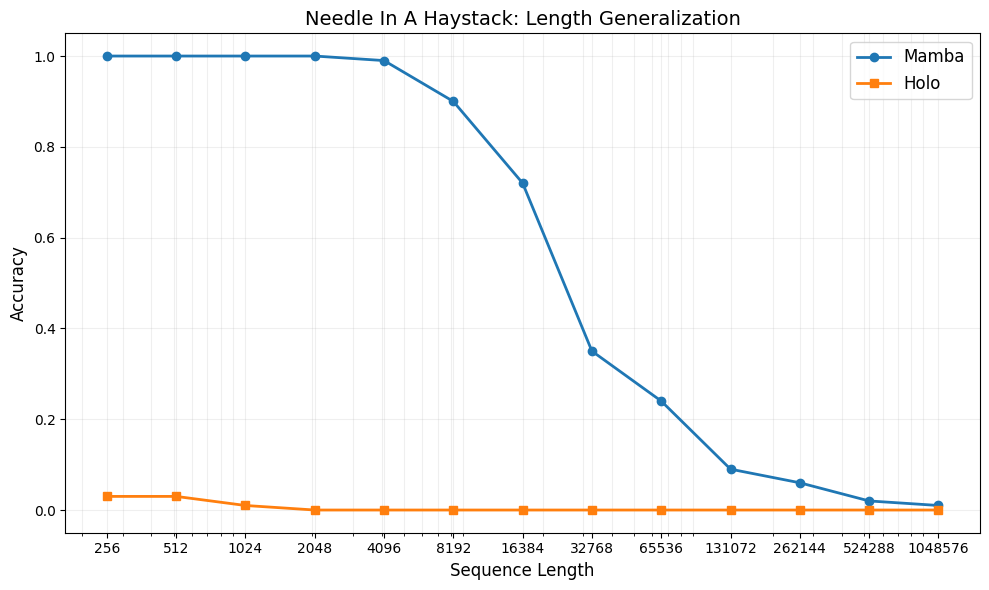

In [13]:
eval_seq_lens=[2**i for i in range(8, 21)]


plt.figure(figsize=(10, 6))

# Plotting Mamba
plt.plot(eval_seq_lens, results_mamba, marker='o', linestyle='-', linewidth=2, label='Mamba')

# Plotting Holo
# plt.plot(eval_seq_lens, results_holo1, marker='s', linestyle='--', linewidth=2, label='Holo')
plt.plot(eval_seq_lens, results_holo, marker='s', linestyle='-', linewidth=2, label='Holo')

# Formatting the X-axis to be Logarithmic (essential for exponential lengths)
plt.xscale('log')
plt.xticks(eval_seq_lens, labels=eval_seq_lens) # Set specific ticks for our lengths

# Labels and Title
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Needle In A Haystack: Length Generalization', fontsize=14)
plt.ylim(-0.05, 1.05) # Keep y-axis range clean
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=12)

# Save the plot
plt.tight_layout()
plt.savefig('niah_results_plot.png')

### Play around